<a href="https://colab.research.google.com/github/CasillasAlba/GeneFlow/blob/main/colab_files/Prueba_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================
# CONEXIÓN CON GOOGLE DRIVE
# ============================================================

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # Se monta el Drive
from google.colab import files

# Instalamos Kaleido ya que colab no lo tiene instalado
!pip install -U kaleido

# ============================================================
# USO DE FICHEROS .PY COMO MÓDULO EN COLAB
# ============================================================

In [ ]:
!cp /content/drive/MyDrive/TFG/GeneFlow/src/dataobject.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/etl.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/model.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/objects.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/processing.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/utils.py /content
!cp /content/drive/MyDrive/TFG/GeneFlow/src/visualize.py /content

!cp /content/drive/MyDrive/TFG/GeneFlow/geneflow.py /content

# ============================================================
# IMPORTAMOS GENEFLOW
# ============================================================

In [ ]:
import geneflow as genf
# Se añade GaussianNB para poder utilizar algoritmos de Aprendizaje Automático
# externos a los ofrecidos.
from sklearn.naive_bayes import GaussianNB

# ============================================================
# INTRODUCCIÓN AL ANÁLISIS
# ============================================================

El cáncer de mama se entiende cada vez más como una designación general para varios subtipos y estratos de tumores que difieren en sus pronósticos y respuestas a la terapia (*Goodman, S. N., Marchionni, L., & Wolff, A. C. (2008). Are short-term or long-term recurrence rates more important in breast cancer screening? Annals of internal medicine, 149(5), 357-358. https://doi.org/10.7326/0003-4819-149-5-200809020-00015*)

Con este análisis, se intentará investigar si la expresión génica en el cáncer de mama contiene información sobre las características patológicas de estadiaje de la enfermedad en pacientes.

El análisis se basa en la clasificación, al detectar las diferencias de expresión génica entre varios genes simultáneamente y predecir las etapas patológicas del cáncer de mama en función de esas características.

Un análisis de este tipo podría aplicarse a la detección temprana del cáncer y al tratemiento personalizado con precisión a nivel genético. También, se podría utilizar este modelo para conocer qué genes tienen más influencia en las diferentes etapas del cáncer de mama y así comprender mejor la diferencia en expresión genética de la enfermedad a nivel molecular.

# ============================================================
# DESCARGA DE DATOS DE GDC
# ============================================================

Los datos para este análisis se obtienen del portal de GDC (Genomic Data Commons). Para ello, se realizará una petición a la API de GDC para descargar datos relativos al cáncer de mama (Breast Invasive Carcinoma, TCGA-BRCA. *Fuente: https://portal.gdc.cancer.gov/projects/TCGA-BRCA*).

Mediante la petición a la API, el usuario puede elegir qué tipo de datos de un proyecto puede descargar. En nuestro caso, se descargan datos de secuenciación del ARN del cáncer de mama.

Además, se descarga también la información clínica de los pacientes para este mismo cáncer.

In [ ]:
gdc_query = genf.create_gdc_query(project = "TCGA-BRCA", data_category = "TRANSCRIPTOME PROFILING", data_type = "Gene Expression Quantification",
                       experimental_strategy = "RNA-Seq")

genf.gdc_download_data(gdc_query)

Searching in GDC database
Accessing GDC. This might take a while...

Project TCGA-BRCA
Checking if the parameters are correct...




In [ ]:
genf.gdc_download_clinical_data("TCGA-BRCA", "patient", legacy = True)

Searching in GDC database
Accessing GDC. This might take a while...

Project TCGA-BRCA
Checking clinical information...



# ============================================================
# LECTURA DE DATOS
# ============================================================

Una vez descargados los datos, se procede a la lectura de los mismos. Para este análisis, se lee la matriz de conteo, la cual contiene el número de lecturas (alineadas contra un genoma) que cuantifican el número de secuencias de ARN asociadas a cada posición del genoma; para cada una de las muestras. 

También se lee la información clínica de las muestras previamente descargada, y un archivo que contiene información de cada uno de los genes (nombre y tipo).

In [ ]:
count_data = genf.read_file("/content/drive/MyDrive/TFG/GeneFlow/data/brca_counts.txt", index = "gene_id", sep="\t")

count_data.head()

,TCGA-D8-A1XO-01A-11R-A14M-07,TCGA-AN-A0FN-01A-11R-A034-07,TCGA-AC-A62X-01A-11R-A29R-07,TCGA-E2-A14U-01A-11R-A22K-07,TCGA-E9-A1R3-01A-31R-A14M-07,TCGA-BH-A18M-01A-11R-A12D-07,TCGA-E2-A15T-01A-11R-A115-07,TCGA-AR-A0TU-01A-31R-A109-07,TCGA-EW-A1IX-01A-12R-A144-07,TCGA-B6-A408-01A-12R-A24H-07,...,TCGA-B6-A0RN-01A-12R-A084-07,TCGA-AC-A2FB-01A-11R-A17B-07,TCGA-AC-A7VB-01A-11R-A352-07,TCGA-A2-A0YM-01A-11R-A109-07,TCGA-OL-A5D8-01A-11R-A27Q-07,TCGA-D8-A1XL-01A-11R-A14M-07,TCGA-AR-A252-01A-11R-A169-07,TCGA-BH-A18G-01A-11R-A12D-07,TCGA-OL-A5D6-01A-21R-A27Q-07,TCGA-A8-A086-01A-11R-A00Z-07
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,4370,2443,3508,6928,2890,1635,3456,8943,1410,1899,...,2465,4518,3958,5469,2212,3321,2586,2127,1417,4263
ENSG00000000005.6,7,144,7,17,4,101,22,10,14,4,...,2,10,18,9,0,0,286,0,2,9
ENSG00000000419.13,2625,2322,2421,1812,4025,1565,1779,2621,1431,2167,...,1387,1657,2113,2153,1184,3880,1655,742,1138,2071
ENSG00000000457.14,3005,1466,839,1651,2769,1183,2176,1804,1556,1516,...,2088,2009,1830,985,1426,1559,1723,911,904,1101
ENSG00000000460.17,1578,409,744,366,663,419,864,2349,318,417,...,464,739,931,1452,343,880,600,328,233,717


In [ ]:
clinical_data = genf.gdc_read_clinical("/content/TCGA-BRCA/nationwidechildrens.org_clinical_patient_brca.txt")

clinical_data.head()

,bcr_patient_uuid,form_completion_date,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,days_to_birth,gender,menopause_status,race,ethnicity,other_dx,...,icd_o_3_histology,icd_o_3_site,informed_consent_verified,distant_metastasis_present_ind2,patient_id,project_code,tumor_tissue_site_other,stage_other,tissue_source_site,tumor_tissue_site
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,6E7D5EC6-A469-467C-B748-237353C23416,2014-1-13,NO,YES,-20211,FEMALE,Pre (<6 months since LMP AND no prior bilatera...,WHITE,NOT HISPANIC OR LATINO,No,...,8520/3,C50.9,YES,[Not Available],AAAU,[Not Available],[Not Applicable],[Not Available],3C,Breast
TCGA-3C-AALI,55262FCB-1B01-4480-B322-36570430C917,2014-7-28,NO,YES,-18538,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,8500/3,C50.9,YES,[Not Available],AALI,[Not Available],[Not Applicable],[Not Available],3C,Breast
TCGA-3C-AALJ,427D0648-3F77-4FFC-B52C-89855426D647,2014-7-28,NO,YES,-22848,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,8500/3,C50.9,YES,[Not Available],AALJ,[Not Available],[Not Applicable],[Not Available],3C,Breast
TCGA-3C-AALK,C31900A4-5DCD-4022-97AC-638E86E889E4,2014-7-28,NO,YES,-19074,FEMALE,[Unknown],BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,No,...,8500/3,C50.9,YES,[Not Available],AALK,[Not Available],[Not Applicable],[Not Available],3C,Breast
TCGA-4H-AAAK,6623FC5E-00BE-4476-967A-CBD55F676EA6,2014-11-13,YES,NO,-18371,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,No,...,8520/3,C50.9,YES,[Not Available],AAAK,[Not Available],[Not Applicable],[Not Available],4H,Breast


In [ ]:
gene_info = genf.read_file("/content/drive/MyDrive/TFG/GeneFlow/data/gene_info_brca.tsv", index = "gene_id", sep="\t")

gene_info.head()

,gene_name,gene_type
gene_id,,
ENSG00000000003.15,TSPAN6,protein_coding
ENSG00000000005.6,TNMD,protein_coding
ENSG00000000419.13,DPM1,protein_coding
ENSG00000000457.14,SCYL3,protein_coding
ENSG00000000460.17,C1orf112,protein_coding


# ============================================================
# CREACIÓN DEL OBJETO DATAOBJECT
# ============================================================

Con el objeto DataObject, el usuario podrá trabajar simultánemanete con los conjuntos de datos que necesite, sin la necesidad de actualizar cada uno de los conjuntos de datos involucrados cuando se modifique la estructuras de los mismos.

Nótese, que el nombre de las muestras leidas en la matriz de conteo es más largo que el encontrado en la información clínica. A la hora de crear el DataObject, este encuentra la sub-cadena que alinea la información de RNA-Seq con la clínica. Se mantiene el nombre del substring encontrado para que la información en ambos conjuntos de datos coincidan. 

In [ ]:
data_object = genf.create_data_object(count_data, obs_ = clinical_data, var_ = gene_info)

data_object.summary_object()


Creating DataObject...


##############################################

Data Object
	Dimensions:  (60660, 1225)
	Row Names (60660): ENSG00000000003.15 ... ENSG00000288675.1
	Column Names (1225): TCGA-3C-AAAU ... TCGA-Z7-A8R6

	Var
		Dimensions:  (60660, 2)
		Row Names (60660): ENSG00000000003.15 ... ENSG00000288675.1
		Column Names (2): gene_name ... gene_type

	Obs
		Dimensions:  (1094, 111)
		Row Names (1094): TCGA-3C-AAAU ... TCGA-Z7-A8R6
		Column Names (111): bcr_patient_uuid ... tumor_tissue_site

##############################################


# ============================================================
# REEMPLAZO DE VALORES NO PROCESABLES
# ============================================================

El conjunto de datos clínico tiene valores difíciles de procesar cuando hay uina falta de información. En concreto, algunos de los valores se pueden encontrar como "[Discrepancy]", , "[Not Available]" y "[Not Applicable]". Esta notación varía de un conjunto clínico a otro y añade una dificultad extra a la hora de trabajar con los datos.

Aunque no se quiere eliminar esta información, se decide reemplazar estos valores por un único valor que indique la falta de disponibilidad del dato, en concreto: NAN.

In [ ]:
data_object = genf.obs_replace(data_object, to_replace = [ "[Discrepancy]", "[Not Available]", "[Not Applicable]"])

# ============================================================
# FILTRADO DE MUESTRAS
# ============================================================

Para conocer un poco más sobre los datos clínicos descargados, se comprueba la distribución de los datos por género y tipo histológico de las muestras.

In [ ]:
print("Distributción de las muestras por género:\n")

genf.count_types(data_object.get_obs(), "gender")


print("\n\n")
print("Distribución de las muestras por tipo histologico:\n")


genf.count_types(data_object.get_obs(), "histological_type")

Distributción de las muestras por género:

FEMALE    1082
MALE        12
Name: gender, dtype: int64 




Distribución de las muestras por tipo histologico:

Infiltrating Ductal Carcinoma       783
Infiltrating Lobular Carcinoma      203
Other, specify                       45
Mixed Histology (please specify)     29
Mucinous Carcinoma                   17
Metaplastic Carcinoma                 9
Medullary Carcinoma                   6
Infiltrating Carcinoma NOS            1
Name: histological_type, dtype: int64 



Del conjunto de datos clínico, nos quedaremos únicamente con aquellas muestras que tengan como género "Femenino" y el tipo histológico más frecuente, es decir, "Infiltrating Ductal Carcinoma". Para ello, se calcula una selección de los datos en los que se mantienen únicamente las filas (muestras) que cumplen la condicición previamente descrita.

Se actualiza el objeto DataObject reemplazando el conjunto de datos de las observaciones por el sub-DataFrame calculado y, a continuación, filtramos por el estadío patológico.

In [ ]:
series_condition_rows = (data_object.get_obs()["histological_type"].str.lower() == 'infiltrating ductal carcinoma') & (data_object.get_obs()["gender"].str.lower() == 'female')

# Nos quedamos con un sub-DataFrame de las muestras de genero femenino y que tiene el tipo histologico más frecuente, es decir,
# ¨Infiltrating Ductal Carcinoma¨
extracted_by_series = genf.data_selection_series(series_condition_rows, data_object.get_obs())

# Actualizamos el objeto DataObject
data_object = genf.set_obs(data_object, extracted_by_series)

# Filtramos por estadio patologico
genf.count_types(data_object.get_obs(), "pathologic_stage")

Stage IIA     263
Stage IIB     179
Stage IIIA    106
Stage I        69
Stage IA       66
Stage IIIC     29
Stage IIIB     19
Stage IV       16
Stage X         9
Stage IB        5
Stage II        3
Name: pathologic_stage, dtype: int64 



# ============================================================
# ASIGNACIÓN DE UNA ETIQUETA A CADA MUESTRA DE LOS DATOS
# ============================================================
Se dividen las muestras en función a las etapas patolóficas del cancer de mama, creando dos etiquetas (grupos):

# ETAPAS LOCALIZADAS/TEMPRANAS
ETIQUETA = 0 (Etapas I y II): Las células cancerígenas aún no se han extendido a otras partes del cuerpo. Hay pocos ganglios linfáticos involucrados. La mayoría de estos tumores son de menos de 50mm.

# ETAPAS DE METÁSTASIS/TARDÍAS
ETIQUETA = 1 (Etapas II & IV): El cáncer se ha extendido a través de los ganglios linfáticos a otras áreas, produciendo metástasis. Generalmente los tumores son mayores de 50mm.

*Fuente de la fotografía: https://es.slideshare.net/angelicashantay/cancer-de-mama-67422691*


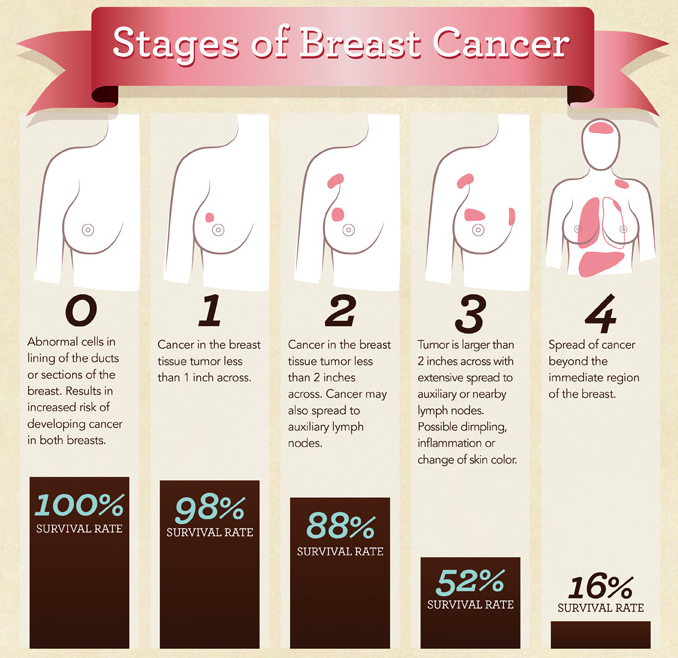

Por tanto, se crea una nueva columna "label" de ceros y unos, dependiendo de la etapa del cáncer.

Se le pasa como argumento la lista de valores que tendrá valor 0 y, el resto, tendrá un valor de 1.

Como se puede observar en el resultado, nos encontramos ante un conjunto de datos no balanceado.

In [ ]:
obs_with_label = genf.add_label(data_object.get_obs(), ['stage i','stage ia','stage ib','stage ii','stage iia','stage iib'], "pathologic_stage", "label")

data_object = genf.set_obs(data_object, obs_with_label)

genf.count_types(data_object.get_obs(), "label")

0    585
1    187
Name: label, dtype: int64 



# ============================================================
# CARACTERÍSTICAS CLÍNICAS
# ============================================================

En un intento de encontrar una relación con otros tipos de variables, se agrupa por la edad en la que ocurrió el primer diagnóstico y la raza, aunque no se puede obtener ninguna conclusión evidente.

In [ ]:
clinical = genf.data_projection_list(data_object.get_obs(), ["age_at_initial_pathologic_diagnosis","race"])


for i in clinical.columns.drop("age_at_initial_pathologic_diagnosis"):
    print(data_object.get_obs().groupby([i, "label"]).count().iloc[:,1])
    

data_object.get_obs()["age_at_initial_pathologic_diagnosis"] = data_object.get_obs()["age_at_initial_pathologic_diagnosis"].astype(float)


data_subtype = genf.copy_object(data_object.get_obs())

race                              label
AMERICAN INDIAN OR ALASKA NATIVE  1          1
ASIAN                             0         37
                                  1         10
BLACK OR AFRICAN AMERICAN         0        114
                                  1         36
WHITE                             0        386
                                  1        111
Name: form_completion_date, dtype: int64


# ============================================================
# DIAGRAMA DE CAJAS
# ============================================================

Se muestra un diagrama de cajas con la relación entre la edad en la que el cáncer fue diadgnosticado, y el estadío del cáncer.

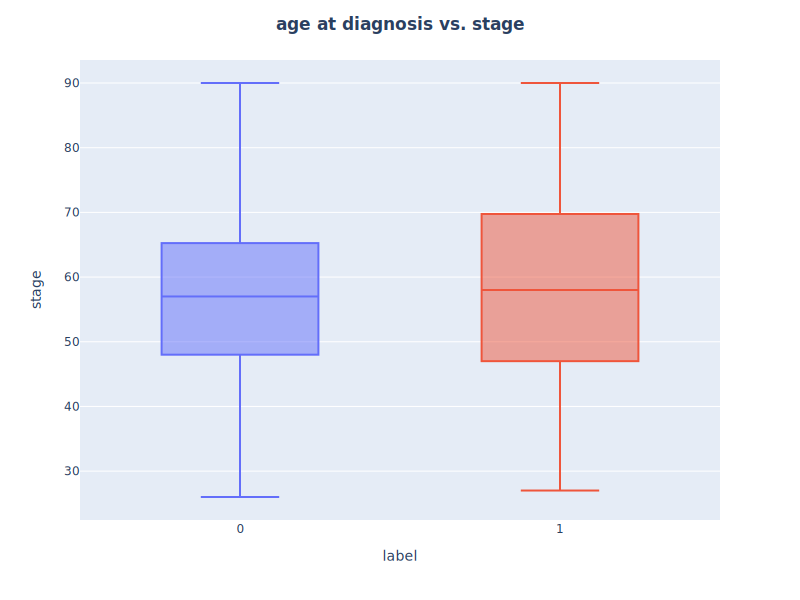

In [ ]:
fig = genf.box_plot(data_object.get_obs(), x = "label", y= "age_at_initial_pathologic_diagnosis")

genf.show_figure(fig, xlabel = "label", ylabel = "stage", legend = False, title = "age at diagnosis vs. stage")

In [ ]:
data_object.summary_object()


##############################################

Data Object
	Dimensions:  (60660, 878)
	Row Names (60660): ENSG00000000003.15 ... ENSG00000288675.1
	Column Names (878): TCGA-3C-AALI ... TCGA-WT-AB41

	Var
		Dimensions:  (60660, 2)
		Row Names (60660): ENSG00000000003.15 ... ENSG00000288675.1
		Column Names (2): gene_name ... gene_type

	Obs
		Dimensions:  (772, 112)
		Row Names (772): TCGA-3C-AALI ... TCGA-WT-AB41
		Column Names (112): bcr_patient_uuid ... label

##############################################


# ============================================================
# ELIMINACIÓN Y REEMPLAZO DE VALORES
# ============================================================

Eliminamos las filas de genes las cuales contengan más de un 10% de valores NAN, puesto que serán considerados genes con poca importancia/poco expresados en el análisis.

Para poder trbajar con el conjunto de datos, no podemos mantener valores NAN; por tanto, aquellas filas con menos del 10% de valores NAN, serán procesados y sustituidos por el cálculo de la media del resto de valores.

In [ ]:
# Reemplazamos los ceros por NAN
data_object = genf.counts_replace(data_object, to_replace = 0)

# Se calcula el umbral (10%)
min_count = genf.thresh_by_perc(data_object.get_counts(), 10.0, axis = 1)

# Se eliminan los valores NAN que superen el umbral pasado como argumento
data_object = genf.counts_drop_nan_by_thresh(data_object, 0, min_count)

# Se reemplaza el resto de valores NAN. CRITERIO: La media del resto de valores.
data_object = genf.counts_replace_nan(data_object)

Como se puede observar, se ha pasado de trabajar con más de 60 mil genes, a únicamente tener unos 22 genes.

Nótese, que aunque se ha trabajado en todo momento con la matriz de conteo, el número de filas en el conjunto de datos "variables" también ha sido actualizado, manteniendo en todo momento la misma cantidad de información.

In [ ]:
data_object.summary_object()


##############################################

Data Object
	Dimensions:  (22689, 878)
	Row Names (22689): ENSG00000000003.15 ... ENSG00000288675.1
	Column Names (878): TCGA-3C-AALI ... TCGA-WT-AB41

	Var
		Dimensions:  (22689, 2)
		Row Names (22689): ENSG00000000003.15 ... ENSG00000288675.1
		Column Names (2): gene_name ... gene_type

	Obs
		Dimensions:  (772, 112)
		Row Names (772): TCGA-3C-AALI ... TCGA-WT-AB41
		Column Names (112): bcr_patient_uuid ... label

##############################################


# ============================================================
# CÁLCULO DE TRASPUESTA
# ============================================================

Se calcula la traspuesta de los datos. Como únicamente se querrá este paso para sacar conclusiones/otra información, el DataObject no será actualizado; simplemente su valor será guardado en una variable temporal "data_transpose".

In [ ]:
data_transpose = genf.transpose(data_object.get_counts())

data_transpose.head()

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288586.1,ENSG00000288596.2,ENSG00000288597.1,ENSG00000288598.1,ENSG00000288612.1,ENSG00000288658.1,ENSG00000288663.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-3C-AALI,418.0,2.0,1818.0,2437.0,490.0,388.0,1755.0,1458.0,1621.0,1252.0,...,37.0,144.0,2.0,17.0,78.0,29.0,47.0,277.0,9.0,45.0
TCGA-3C-AALJ,1303.0,52.0,1281.0,380.0,239.0,371.0,972.0,767.0,685.0,731.0,...,20.0,299.0,4.0,15.0,43.0,27.0,35.0,148.0,5.0,27.0
TCGA-3C-AALK,2969.0,4.0,1386.0,1315.0,460.0,384.0,2672.0,1530.0,1452.0,2550.0,...,27.0,151.0,5.0,21.0,82.0,9.0,44.0,277.0,14.0,54.0
TCGA-A1-A0SD,2477.0,50.0,2775.0,1430.0,375.0,412.0,4946.0,3367.0,3738.0,3883.0,...,16.0,158.0,12.0,21.0,36.0,18.0,25.0,352.0,2.0,19.0
TCGA-A1-A0SF,8999.0,9.0,1624.0,1263.0,453.0,577.0,2732.0,1417.0,1418.0,2820.0,...,15.0,95.0,5.0,22.0,21.0,8.0,19.0,434.0,4.0,32.0


# ============================================================
# SELECCIÓN DE VALORES
# ============================================================

A continuación, se calcula la varianza de los genes. Después, se selecciona los 1000 genes que muestran la mayor variabilidad en sus niveles de expresión.

En todo momento se está trabajando con el id de los genes. Sin embargo, se almacena en una variable diccionario el nombre correspondiente a cada uno de los 1000 genes con mayor varianza.

In [ ]:
# Calculamos la varianza de los genes
var = genf.variance(data_transpose)

# Calculamos una lista con los 1000 mejores genes
var_1000 = genf.top_variables(var, 1000)

# Se crea un diccionario que combina el id y el nombre de los genes
gnames = genf.data_zip(data_object.get_var(), "gene_id", "gene_name")

# Este diccionario almacena para cada id de los 1000 mejores genes, el nombre de los mismos.
genes_1000 = genf.filter_dictionary(gnames, var_1000)

print(genes_1000)

{'ENSG00000002834.18': 'LASP1', 'ENSG00000003989.18': 'SLC7A2', 'ENSG00000004478.8': 'FKBP4', 'ENSG00000004799.8': 'PDK4', 'ENSG00000005893.16': 'LAMP2', 'ENSG00000006125.18': 'AP2B1', 'ENSG00000006210.7': 'CX3CL1', 'ENSG00000006831.10': 'ADIPOR2', 'ENSG00000007062.12': 'PROM1', 'ENSG00000008283.16': 'CYB561', 'ENSG00000008394.13': 'MGST1', 'ENSG00000008441.18': 'NFIX', 'ENSG00000008513.16': 'ST3GAL1', 'ENSG00000008838.20': 'MED24', 'ENSG00000008988.11': 'RPS20', 'ENSG00000009307.16': 'CSDE1', 'ENSG00000010278.15': 'CD9', 'ENSG00000011465.18': 'DCN', 'ENSG00000012223.13': 'LTF', 'ENSG00000012660.14': 'ELOVL5', 'ENSG00000013583.10': 'HEBP1', 'ENSG00000013588.9': 'GPRC5A', 'ENSG00000019505.8': 'SYT13', 'ENSG00000019582.15': 'CD74', 'ENSG00000022267.19': 'FHL1', 'ENSG00000026025.16': 'VIM', 'ENSG00000026508.20': 'CD44', 'ENSG00000030582.18': 'GRN', 'ENSG00000034510.6': 'TMSB10', 'ENSG00000035403.18': 'VCL', 'ENSG00000035862.12': 'TIMP2', 'ENSG00000038427.16': 'VCAN', 'ENSG00000039068.19':

A parte de los 1000 genes con mayor variabilidad, se añadirán 7 de los genes más importantes en el estudio del cáncer de mama (si no están ya previamente añadidos entre los 1000 elegidos).

*   MYC como el gen de cáncer CNA (copy number alteration) más frecuente (generado desde datos BRC de TCGA, Firehose Legacy, PanCancer Atlas)
*   PIK3CA y TP53 como los genes cancerígenos mutados más frequentes (generados desde datos BRC de TCGA, Firehose Legacy, PanCancer Atlas)
*   BRCA1, BRCA2, CDH1 y PTEN como mutaciones de genes de alta a moderadamente penetrantes.

De estos genes, se conoce únicamente el nombre, pero no el id que se le corresponde. Por ello, el diccionario creado anteriormente nos servirá para encontrar el id correspondiente a partir de su nombre.

Como resultado, vemos que los conjuntos de datos "counts" y "vars" contienen ambos 1006 genes (lo que quiere decir que uno de los genes más comunes en este cáncer ya estaba previamente añadido).

In [ ]:
genes_7 = ["MYC", "PIK3CA", "TP53", "BRCA1", "BRCA2", "CDH1", "PTEN"]
lkgenes_7 = []

# De entre los 7 genes mas comunes
for gen in genes_7:
    # Si no están ya entre los 1000 genes con mas varianza
    if gen not in list(genes_1000.values()):
        # Se obtiene su ID correspondiente y se añade a la lista de genes
        kgenes_7 = list(gnames.keys())[list(gnames.values()).index(gen)]
        lkgenes_7.append(kgenes_7)
        
# Actualizamos el objeto DataObject con los genes seleccionados. 
data_object = genf.counts_selection(data_object, (list(genes_1000.keys()) + lkgenes_7))

data_object.summary_object()


##############################################

Data Object
	Dimensions:  (1006, 878)
	Row Names (1006): ENSG00000002834.18 ... ENSG00000171862.11
	Column Names (878): TCGA-3C-AALI ... TCGA-WT-AB41

	Var
		Dimensions:  (1006, 2)
		Row Names (1006): ENSG00000002834.18 ... ENSG00000171862.11
		Column Names (2): gene_name ... gene_type

	Obs
		Dimensions:  (772, 112)
		Row Names (772): TCGA-3C-AALI ... TCGA-WT-AB41
		Column Names (112): bcr_patient_uuid ... label

##############################################


# ============================================================
# CÁLCULO DE CORRELACIÓN ENTRE VARIABLES
# ============================================================

A continuación, se calcula la correlación de Pearson entre las columnas.

In [31]:
print("Cálculo de la correlación entre las muestras\n")

corr = genf.var_correlation(data_object.get_counts())

corr.head()

Cálculo de la correlación entre las muestras



,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-A1-A0SD,TCGA-A1-A0SF,TCGA-A1-A0SH,TCGA-A1-A0SI,TCGA-A1-A0SJ,TCGA-A1-A0SN,TCGA-A1-A0SO,...,TCGA-S3-AA10,TCGA-S3-AA11,TCGA-S3-AA12,TCGA-S3-AA14,TCGA-S3-AA15,TCGA-S3-AA17,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-WT-AB41
TCGA-3C-AALI,1.000000,0.798154,0.792348,0.537693,0.664408,0.561513,0.569240,0.684155,0.766634,0.602810,...,0.536860,0.696346,0.584052,0.726043,0.400347,0.675536,0.631690,0.589070,0.508871,0.518215
TCGA-3C-AALJ,0.798154,1.000000,0.864212,0.633471,0.830823,0.555295,0.574824,0.831974,0.692238,0.714628,...,0.565409,0.849103,0.717434,0.753502,0.356425,0.793012,0.681007,0.590490,0.616752,0.618081
TCGA-3C-AALK,0.792348,0.864212,1.000000,0.586937,0.758209,0.826675,0.813502,0.717783,0.848171,0.562578,...,0.463466,0.766770,0.643675,0.900622,0.309537,0.598769,0.525751,0.429709,0.617620,0.492324
TCGA-A1-A0SD,0.537693,0.633471,0.586937,1.000000,0.608658,0.411480,0.439984,0.628230,0.529761,0.485570,...,0.274939,0.655995,0.468061,0.538476,0.138176,0.489682,0.511365,0.405770,0.376261,0.332962
TCGA-A1-A0SF,0.664408,0.830823,0.758209,0.608658,1.000000,0.421206,0.434127,0.813982,0.654228,0.705080,...,0.441755,0.904000,0.684701,0.668765,0.209332,0.705905,0.651748,0.623069,0.593576,0.565713


Eliminación de variables correlacionadas

In [42]:
data_remov = genf.remove_correlation(data_object.get_counts(), 0.6)

In [51]:
genes = genf.data_selection_list(data_remov, list(data_subtype.index.values))

genes_500 = genf.top_variables(genes, 507)

genes = genf.data_selection_list(genes, genes_500)

In [54]:
final_data = genes

# Se añade a los datos finales la columna "label" calculada anteriormente
final_data["label"] = data_subtype.label

datos_ml = final_data.copy()

# ============================================================
# MACHINE LEARNING
# ============================================================

Se muestran los datos a los que aplicar Machine Learning

In [55]:
datos_ml.head()

,ENSG00000002834.18,ENSG00000003989.18,ENSG00000004478.8,ENSG00000006125.18,ENSG00000006831.10,ENSG00000007062.12,ENSG00000008394.13,ENSG00000008441.18,ENSG00000008513.16,ENSG00000010278.15,...,ENSG00000277443.3,ENSG00000277791.5,ENSG00000278771.1,ENSG00000136997.21,ENSG00000121879.6,ENSG00000141510.18,ENSG00000012048.23,ENSG00000139618.16,ENSG00000171862.11,label
TCGA-3C-AALI,9835.0,1648.0,9006.0,33437.0,4133.0,29.000000,3814.0,1071.0,3291.0,17328.0,...,6510.0,26207.0,34.0,275.0,946.0,874.0,789.0,443.0,2346.0,0
TCGA-3C-AALJ,20778.0,2980.0,6593.0,5971.0,12755.0,1016.043337,9659.0,550.0,4741.0,2853.0,...,4327.0,6782.0,7.0,1181.0,405.0,1544.0,251.0,292.0,1985.0,0
TCGA-3C-AALK,59958.0,9267.0,14304.0,33101.0,3613.0,278.000000,12771.0,4337.0,2813.0,21320.0,...,12176.0,18102.0,4.0,2883.0,1134.0,3596.0,402.0,370.0,5357.0,0
TCGA-A1-A0SD,19902.0,136826.0,19526.0,24084.0,56352.0,1274.000000,2436.0,6153.0,12462.0,35458.0,...,17803.0,4923.0,3.0,6105.0,3071.0,4072.0,911.0,392.0,7246.0,0
TCGA-A1-A0SF,24177.0,8760.0,19130.0,24157.0,5051.0,303.000000,2713.0,7309.0,3669.0,33628.0,...,7791.0,4763.0,1.0,3685.0,1701.0,4319.0,697.0,358.0,6692.0,0


# Primer modelo

Usamos todos los genes obtenidos.

In [57]:
print("MODELO UNO:")

data = genf.create_model_selection(final_data.copy())

data.split_data()

data.get_train_test_sample(test_size = 0.2, resample = True)

data.standarize()

print("\n\n")
models = []

models.append(genf.model_logistic_regression('LR', solver='lbfgs', max_iter=1000))
models.append(genf.model_random_forest('RF', n_estimators=500))
models.append(genf.model_scikit_learn('GNB', GaussianNB()))
models.append(genf.model_support_vector_classif('SVC', kernel = 'sigmoid',probability=True))
models.append(genf.model_neural_network('MLP', max_iter = 500, hidden_layer_sizes=(5,5,5)))

model_results = genf.ut.pd.DataFrame()


for model_for in models:   
    
    print('Entrenando: ', model_for.get_name())
    
    model_for.fit(data.get_X_train(), data.get_Y_train())
    
    # Devuelve la probabilidad de que sea 0 o 1
    predictions_proba = data.predict_proba(model_for)
    # Nos quedamos con los que superen el 50% de la probabilidad
    predictions = data.get_predictions(predictions_proba, 0.5)    
    
    metrics = model_for.get_metrics(data.get_Y_test(), predictions, predictions_proba)
   
    model_results = genf.ut.pd.concat([model_results, metrics], axis=0) 


print(model_results)

MODELO UNO:



Entrenando:  LR
Entrenando:  RF
Entrenando:  GNB
Entrenando:  SVC
Entrenando:  MLP
  model_name  precision    recall  specificity        f1  accuracy
0         LR   0.567901  0.754098     0.611111  0.647887  0.668874
0         RF   0.719298  0.672131     0.822222  0.694915  0.761589
0        GNB   0.480769  0.819672     0.400000  0.606061  0.569536
0        SVC   0.530612  0.426230     0.744444  0.472727  0.615894
0        MLP   0.661765  0.737705     0.744444  0.697674  0.741722


# Segundo modelo

No consideramos los 7 genes más conocidos con el cáncer de BRCA.

In [58]:
print("MODELO DOS:")

tmp = final_data.copy()

data7 = tmp.drop(lkgenes_7,axis=1)

data = genf.create_model_selection(data7)

data.split_data()

data.get_train_test_sample(test_size = 0.2, resample = True)

data.standarize()

print("\n\n")
models = []

models.append(genf.model_logistic_regression('LR', solver='lbfgs', max_iter=1000))
models.append(genf.model_random_forest('RF', n_estimators=500))
models.append(genf.model_scikit_learn('GNB', GaussianNB()))
models.append(genf.model_support_vector_classif('SVC', kernel = 'sigmoid',probability=True))
models.append(genf.model_neural_network('MLP', max_iter = 500, hidden_layer_sizes=(5,5,5)))

model_results = genf.ut.pd.DataFrame()



for model_for in models:   
    
    print('Entrenando: ', model_for.get_name())
    
    model_for.fit(data.get_X_train(), data.get_Y_train())
    
    # Devuelve la probabilidad de que sea 0 o 1
    predictions_proba = data.predict_proba(model_for)
    # Nos quedamos con los que superen el 50% de la probabilidad
    predictions = data.get_predictions(predictions_proba, 0.5)    
    
    metrics = model_for.get_metrics(data.get_Y_test(), predictions, predictions_proba)
   
    model_results = genf.ut.pd.concat([model_results, metrics], axis=0) 

print(model_results)

MODELO DOS:



Entrenando:  LR
Entrenando:  RF
Entrenando:  GNB
Entrenando:  SVC
Entrenando:  MLP
  model_name  precision    recall  specificity        f1  accuracy
0         LR   0.646341  0.779412     0.650602  0.706667  0.708609
0         RF   0.830189  0.647059     0.891566  0.727273  0.781457
0        GNB   0.484211  0.676471     0.409639  0.564417  0.529801
0        SVC   0.641026  0.367647     0.831325  0.467290  0.622517
0        MLP   0.662162  0.720588     0.698795  0.690141  0.708609


# Tercer Modelo

Sólamente considerando los 100 mejores genes.

In [59]:
print("MODELO TRES:")

tmp = final_data.copy()

label = tmp.label

tmp = genf.ut.pd.concat([tmp.iloc[:,:100],tmp.loc[:,lkgenes_7]], axis=1)
dup_cols = tmp.columns[tmp.columns.duplicated()]
tmp.drop(columns = dup_cols, inplace = True)

tmp['label'] = label

data107 = tmp.copy()

data = genf.create_model_selection(data107)

data.split_data()

data.get_train_test_sample(test_size = 0.2, resample = True)

data.standarize()

print("\n\n")
models = []

models.append(genf.model_logistic_regression('LR', solver='lbfgs', max_iter=1000))
models.append(genf.model_random_forest('RF', n_estimators=500))
models.append(genf.model_scikit_learn('GNB', GaussianNB()))
models.append(genf.model_support_vector_classif('SVC', kernel = 'sigmoid',probability=True))
models.append(genf.model_neural_network('MLP', max_iter = 500, hidden_layer_sizes=(5,5,5)))

model_results = genf.ut.pd.DataFrame()



for model_for in models:   
    
    print('Entrenando: ', model_for.get_name())
    
    model_for.fit(data.get_X_train(), data.get_Y_train())
    
    # Devuelve la probabilidad de que sea 0 o 1
    predictions_proba = data.predict_proba(model_for)
    # Nos quedamos con los que superen el 50% de la probabilidad
    predictions = data.get_predictions(predictions_proba, 0.5)    
    
    metrics = model_for.get_metrics(data.get_Y_test(), predictions, predictions_proba)
   
    model_results = genf.ut.pd.concat([model_results, metrics], axis=0) 

print(model_results)

MODELO TRES:



Entrenando:  LR
Entrenando:  RF
Entrenando:  GNB
Entrenando:  SVC
Entrenando:  MLP
  model_name  precision    recall  specificity        f1  accuracy
0         LR   0.555556  0.461538     0.720930  0.504202  0.609272
0         RF   0.777778  0.646154     0.860465  0.705882  0.768212
0        GNB   0.509804  0.800000     0.418605  0.622754  0.582781
0        SVC   0.531250  0.261538     0.825581  0.350515  0.582781
0        MLP   0.642857  0.692308     0.709302  0.666667  0.701987


# Cuarto modelo

Sólamente considerando los 50 mejores genes.

In [60]:
print("MODELO CUATRO:")


tmp = final_data.copy()

label = tmp.label

data = genf.ut.pd.concat([tmp.iloc[:,:50],tmp.loc[:,lkgenes_7]], axis=1)
dup_cols = tmp.columns[tmp.columns.duplicated()]
tmp.drop(columns = dup_cols, inplace = True)

tmp['label']=label

data57 = tmp.copy()   

data = genf.create_model_selection(data57)

data.split_data()

data.get_train_test_sample(test_size = 0.2, resample = True)

data.standarize()

print("\n\n")
models = []

models.append(genf.model_logistic_regression('LR', solver='lbfgs', max_iter=1000))
models.append(genf.model_random_forest('RF', n_estimators=500))
models.append(genf.model_scikit_learn('GNB', GaussianNB()))
models.append(genf.model_support_vector_classif('SVC', kernel = 'sigmoid',probability=True))
models.append(genf.model_neural_network('MLP', max_iter = 500, hidden_layer_sizes=(5,5,5)))

model_results = genf.ut.pd.DataFrame()


for model_for in models:   
    
    print('Fitting: ', model_for.get_name())
    
    model_for.fit(data.get_X_train(), data.get_Y_train())
    
    # Devuelve la probabilidad de que sea 0 o 1
    predictions_proba = data.predict_proba(model_for)
    # Nos quedamos con los que superen el 50% de la probabilidad
    predictions = data.get_predictions(predictions_proba, 0.5)    
    
    metrics = model_for.get_metrics(data.get_Y_test(), predictions, predictions_proba)
   
    model_results = genf.ut.pd.concat([model_results, metrics], axis=0) 

print(model_results)

MODELO CUATRO:



Fitting:  LR
Fitting:  RF
Fitting:  GNB
Fitting:  SVC
Fitting:  MLP
  model_name  precision    recall  specificity        f1  accuracy
0         LR   0.650000  0.742857     0.654321  0.693333  0.695364
0         RF   0.708333  0.485714     0.827160  0.576271  0.668874
0        GNB   0.464286  0.557143     0.444444  0.506494  0.496689
0        SVC   0.538462  0.400000     0.703704  0.459016  0.562914
0        MLP   0.559140  0.742857     0.493827  0.638037  0.609272


# ============================================================
# AJUSTE DE HIPERPARÁMETROS
# ============================================================

Se optimiza el desempeño de Random Forest mediante un ajuste de hiperparémtros (*hyperparameter tuning*). 

Para ello, se prueba con diferentes valores para el parámetro "n_estimators" (10, 50, 100, 50).

El modelo se actualiza con la mejor combinación de parámetros obtenida 

In [61]:
data = genf.create_model_selection(data7)

data.split_data()

data.get_train_test_sample(test_size = 0.2, resample = True)

data.standarize()

random_forest = genf.model_random_forest('RF')

random_forest.hyperparameter_tuning(data.get_X_train(), data.get_Y_train(), n_estimators = [10,50,100,500])

random_forest.fit(data.get_X_train(), data.get_Y_train())

predictions_proba = data.predict_proba(random_forest)
predictions = data.get_predictions(predictions_proba, threshold = 0.5)

metrics = random_forest.get_metrics(data.get_Y_test(), predictions, predictions_proba)

print(metrics)

  model_name  precision   recall  specificity        f1  accuracy
0         RF   0.829268  0.53125      0.91954  0.647619  0.754967


# ============================================================
# CURVA PRECISION-RECALL USANDO UMBRALES
# ============================================================

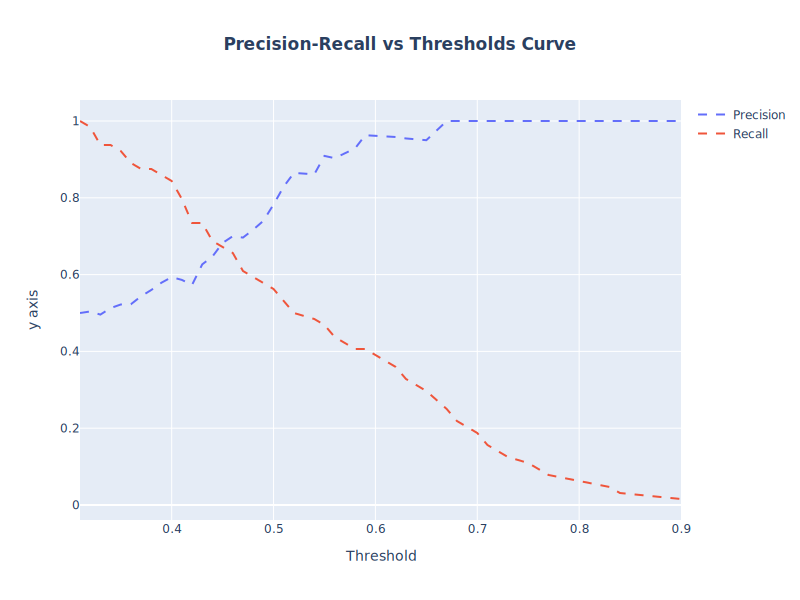

In [62]:
prc_vs_threshold = genf.plot_prec_recall_vs_thresh(data.get_Y_test() , predictions_proba)

genf.show_figure(prc_vs_threshold, xlabel = "Threshold", title = 'Precision-Recall vs Thresholds Curve')

# ============================================================
# MATRIZ DE CONFUSIÓN
# ============================================================

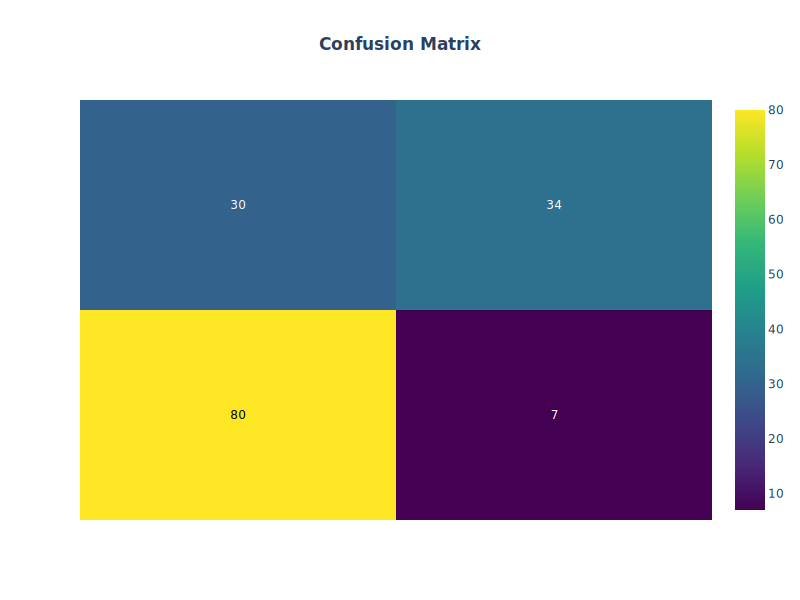

In [63]:
cm = data.confusion_matrix(predictions)

confs = genf.plot_confusion_matrix(cm)

genf.show_figure(confs, xlabel = "", ylabel = "", title = "Confusion Matrix")

# ============================================================
# CURVA ROC
# ============================================================

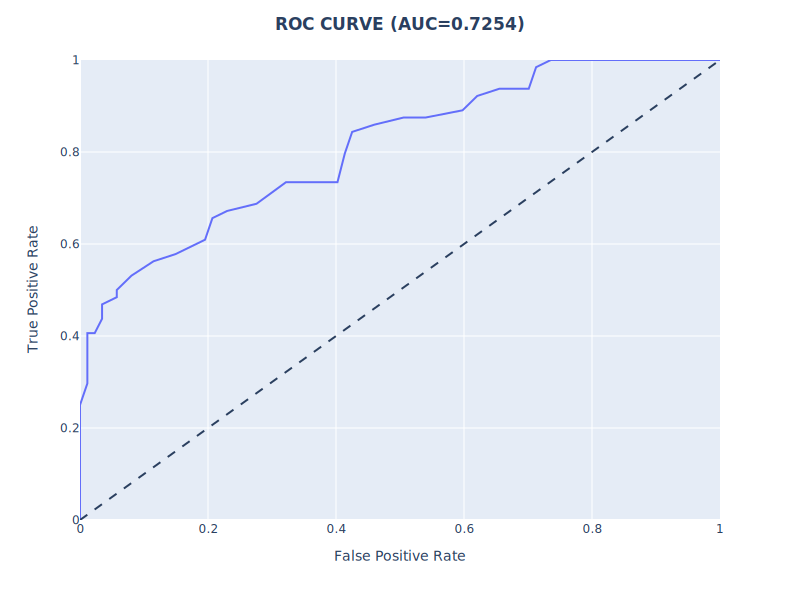

In [64]:
roc_auc = data.calc_auc(predictions)

roc = genf.plot_roc(data.get_Y_test(), predictions_proba)

genf.show_figure(roc, xlabel = "False Positive Rate", ylabel = "True Positive Rate", x_ini_range = 0, x_fin_range = 1,
                    y_ini_range = 0, y_fin_range = 1, title = "ROC CURVE " + f'(AUC={roc_auc:.4f})')

# ============================================================
#CURVA PRECISION-RECALL
# ============================================================

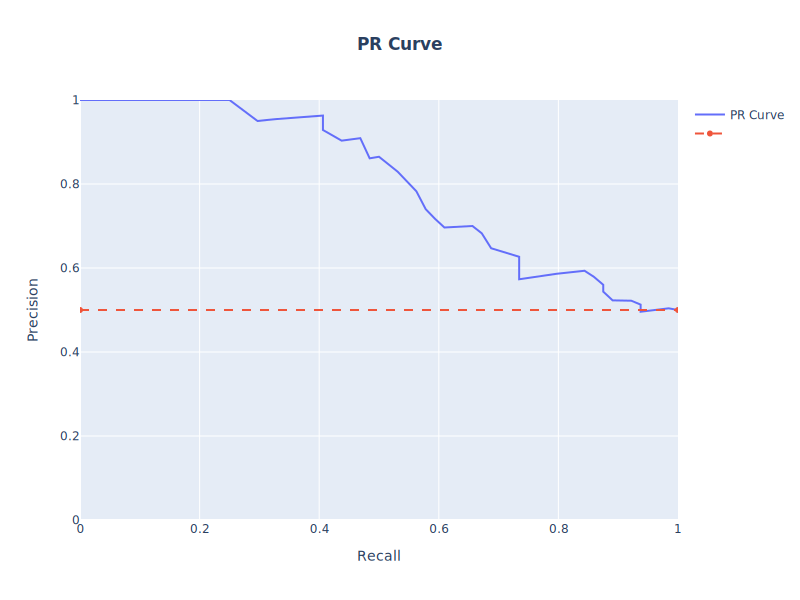

In [65]:
pr_auc = data.calc_auc(predictions, curve = "precision-recall")
title = "PR CURVE " + f'(AUC={pr_auc:.4f})'

pr = genf.plot_prc(data.get_Y_test(), predictions_proba)

genf.show_figure(pr, xlabel = "Recall", ylabel = "Precision", x_ini_range = 0, x_fin_range = 1, y_ini_range = 0, y_fin_range = 1, title = 'PR Curve')